In [188]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

import autofeat

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [282]:
train = pd.read_csv('../data/clean_train2.csv')
test = pd.read_csv('../data/clean_test2.csv')

train2 = pd.read_csv('../data/fe_train1.csv')
test2 = pd.read_csv('../data/fe_test1.csv')

In [9]:
print(train2.info())
train2.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6338 entries, 0 to 6337
Data columns (total 38 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   ServiceSpan                                                 6338 non-null   float64
 1   QuarterlyPayment                                            6338 non-null   float64
 2   GrandPayment                                                6338 non-null   float64
 3   cat_sex_0.0                                                 6338 non-null   float64
 4   cat_sex_1.0                                                 6338 non-null   float64
 5   cat_Aged_0.0                                                6338 non-null   float64
 6   cat_Aged_1.0                                                6338 non-null   float64
 7   cat_Married_0.0                                             6338 non-null   float64
 8 

,ServiceSpan,QuarterlyPayment,GrandPayment,cat_sex_0.0,cat_sex_1.0,cat_Aged_0.0,cat_Aged_1.0,cat_Married_0.0,cat_Married_1.0,cat_TotalDependents_0.0,...,GrandPayment/QuarterlyPayment,Abs(GrandPayment - QuarterlyPayment),cat_CyberProtection_00**3*log(QuarterlyPayment)**3,(cat_CyberProtection_00 + cat_SettlementProcess_30)**2,cat_TechnicalAssistance_00**3*log(QuarterlyPayment)**3,(cat_SettlementProcess_30 + cat_TotalDependents_00)**2,(cat_SettlementProcess_30 + cat_TechnicalAssistance_00)**2,sqrt(cat_Aged_00 + cat_TechnicalAssistance_10),exp(cat_Aged_10 + cat_HardwareSupport_00),CustomerAttrition
0,48.0,96.259802,68.030354,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.706737,28.229448,95.259331,1.0,0.0,0.0,0.0,1.414214,1.0,1


In [5]:
cat_cols = train.select_dtypes(include='int64').columns.tolist()
cat_cols.remove('CustomerAttrition')
cat_cols.remove('ServiceSpan')

train[cat_cols] = train[cat_cols].astype(np.uint8)
test[cat_cols] = test[cat_cols].astype(np.uint8)

In [10]:
X = train2.drop('CustomerAttrition', axis=1)
y = train2['CustomerAttrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=1234)

In [36]:
# cc = train.select_dtypes(include=np.uint8).columns.tolist()
# print(cc)
# af = autofeat.AutoFeatClassifier(verbose=1, feateng_steps=3, categorical_cols=cc)

# X_train_tr = af.fit_transform(X_train, y_train)
# X_test_tr = af.transform(X_test)

['sex', 'Aged', 'Married', 'TotalDependents', 'MobileService', '4GService', 'CyberProtection', 'HardwareSupport', 'TechnicalAssistance', 'FilmSubscription', 'SettlementProcess']
[AutoFeat] The 3 step feature engineering process could generate up to 477946 features.
[AutoFeat] With 4753 data points this new feature matrix would use about 9.09 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 13 transformed features from 28 original features - done.
[feateng] Step 2: first combination of features
[feateng] Generated 3228 feature combinations from 820 original feature tuples - done.
[feateng] Step 3: transformation of new features
[feateng] Generated 10548 transformed features from 3228 original features - done.
[feateng] Generated altogether 15510 new features in 3 steps
[feateng] Removing correlated features, as well as additions at the highest level
[feateng] Generated a total of 5989 additional features
[featsel] Scaling data...done.
[featsel] Feat

In [21]:
X_train_tr

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,...,CyberProtection*ServiceSpan,GrandPayment/QuarterlyPayment,ServiceSpan*TechnicalAssistance,QuarterlyPayment**2/GrandPayment,MobileService*SettlementProcess**3,sqrt(GrandPayment)/QuarterlyPayment,Aged*sqrt(SettlementProcess),QuarterlyPayment*exp(SettlementProcess),Aged/GrandPayment,Aged*exp(x4GService)
0,1.0,0.0,0.0,0.0,8.0,1.0,1.0,1.0,0.0,0.0,...,8.0,0.325050,0.0,300.516185,27.0,0.057685,0.0,1962.010526,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.198629,0.0,373.538146,27.0,0.051741,0.0,1490.256216,0.0,0.0
2,1.0,0.0,1.0,1.0,67.0,1.0,1.0,1.0,0.0,1.0,...,67.0,0.790823,67.0,133.870583,1.0,0.086429,0.0,287.778990,0.0,0.0
3,1.0,0.0,1.0,1.0,49.0,1.0,0.0,1.0,0.0,1.0,...,49.0,0.857659,49.0,81.141789,1.0,0.111014,0.0,189.170721,0.0,0.0
4,0.0,0.0,1.0,0.0,18.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.925912,0.0,23.151389,8.0,0.207832,0.0,158.392854,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748,0.0,0.0,1.0,1.0,53.0,1.0,0.0,1.0,1.0,0.0,...,53.0,1.088278,0.0,40.282989,0.0,0.157558,0.0,43.839091,0.0,0.0
4749,0.0,0.0,1.0,1.0,68.0,1.0,0.0,1.0,0.0,0.0,...,68.0,0.996818,0.0,67.844354,0.0,0.121407,0.0,67.628479,0.0,0.0
4750,0.0,0.0,1.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.781321,0.0,10.965198,1.0,0.301989,0.0,53.094951,0.0,0.0
4751,0.0,0.0,0.0,0.0,10.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.515874,0.0,71.629208,8.0,0.118156,0.0,273.038029,0.0,0.0


# autofeat

In [11]:
rfc = RandomForestClassifier(n_estimators=213, max_depth=7, random_state=1234)

scores = cross_val_score(rfc, X_train, y_train)
print(scores)
print(scores.mean())

[0.79074658 0.8044164  0.79600421 0.81052632 0.77894737]
0.7961281753279096


In [12]:
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=213, random_state=1234)

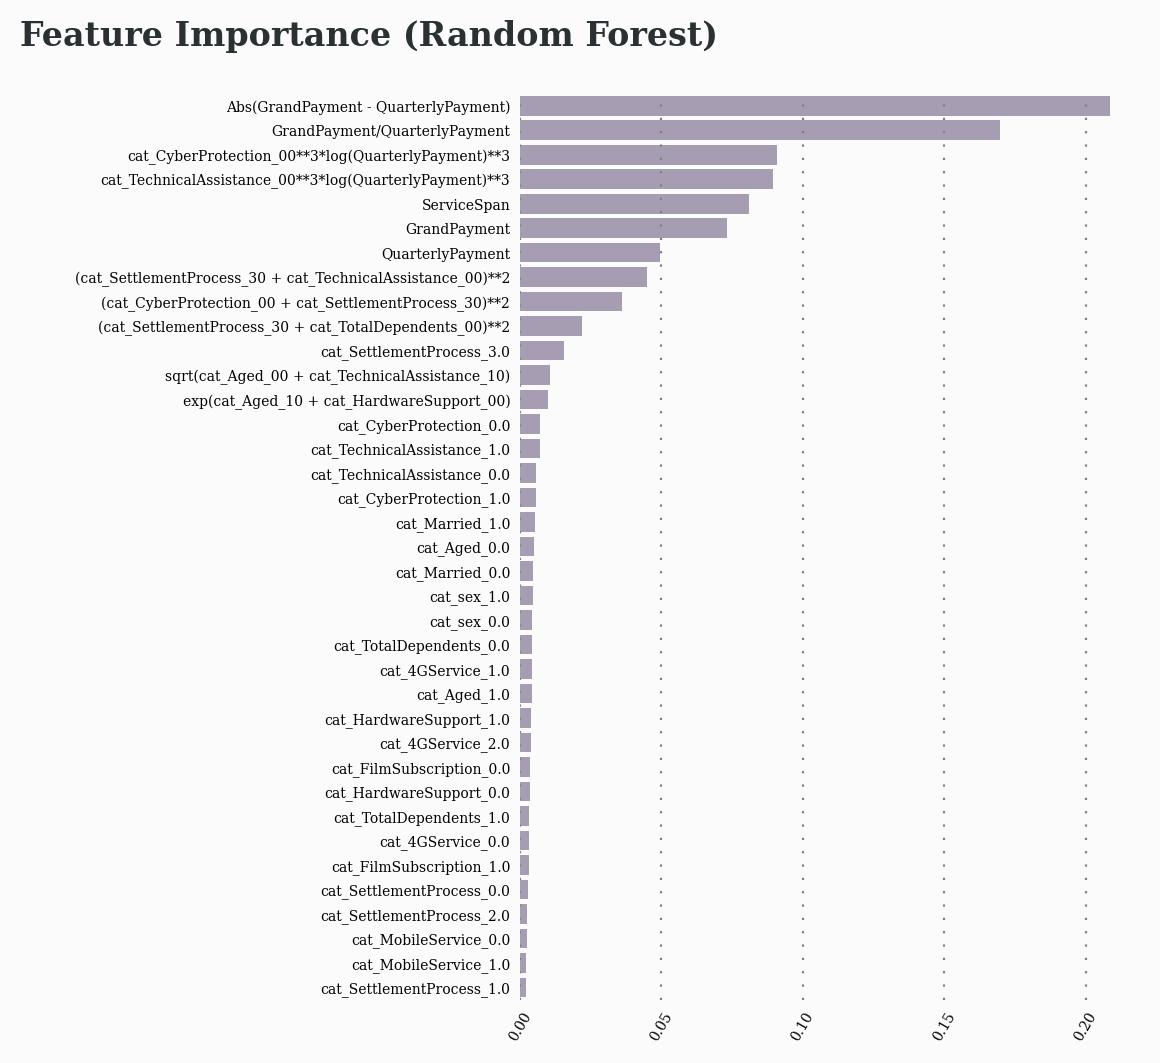

In [38]:
feat_imp = pd.DataFrame({
    'feats': X_train.columns.tolist(),
    'imp': rfc.feature_importances_,
}).sort_values(by='imp', ascending=False)


# Setting up figure and axes
fig = plt.figure(figsize=(4, 6), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=1)
ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

c = ['#a799b7'] * 24
# c[-2] = '#2a3132'
# c[-4] = '#763626'

sns.barplot(data=feat_imp, x='imp', y='feats', palette=c)
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=60, fontsize=5)
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.tick_params(axis='both', which='both', length=0)
ax0.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
for loc in ['left', 'top', 'right', 'bottom']:
    ax0.spines[loc].set_visible(False)

fig.text(-0.5, 0.92, 'Feature Importance (Random Forest)', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')
# fig.text(-0.52, 0.88, 
#          '''
#          All the features have positive skewness except 
#          damage ratio, and we see that err_malign shows 
#          very high skewness.
#          ''',
#          fontsize=5,
#          fontfamily='serif',
#          color='#2a3132',
# )

plt.tight_layout()
plt.show()

In [43]:
new_X = af.transform(X)

[AutoFeat] Computing 9 new features.
[AutoFeat]     9/    9 new features ...done.


In [44]:
new_test = af.transform(test)

[AutoFeat] Computing 9 new features.
[AutoFeat]     9/    9 new features ...done.


In [45]:
new_X['CustomerAttrition'] = y

In [46]:
new_X.to_csv('../data/fe_train1.csv', index=False)
new_test.to_csv('../data/fe_test1.csv', index=False)

# manual FE

In [308]:
train.head()

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
0,0,0,0,1,48,1,2,0,1,1,0,2,96.259802,68.030354,1
1,1,0,1,0,45,1,2,0,0,0,1,0,18.876470,30.365869,0
2,1,1,1,0,59,1,2,1,0,1,0,1,106.016057,78.777479,1
3,1,0,0,0,14,1,2,0,0,0,0,2,80.108839,35.336318,0
4,0,0,1,1,25,1,2,0,1,0,1,2,51.529773,35.851378,0


In [309]:
df = train.append(test).reset_index(drop=True)
df.shape

(7043, 15)

In [310]:
df['GrandPayment'] = df['GrandPayment'] ** 2

In [311]:
df['GP / QP'] = df['GrandPayment'] / df['QuarterlyPayment']
df['GP / ServiceSpan'] =  df['GrandPayment'] / (1 + df['ServiceSpan'])
df['QP / ServiceSpan'] = df['QuarterlyPayment'] / (1 + df['ServiceSpan'])

df['sex_age'] = df.apply(lambda x: f"{int(x['sex'])}_{int(x['Aged'])}", axis=1)
df['sex_married'] = df.apply(lambda x: f"{int(x['sex'])}_{int(x['Married'])}", axis=1)
df['sex_dependent'] = df.apply(lambda x: f"{int(x['sex'])}_{int(x['TotalDependents'])}", axis=1)

df['aged_married'] = df.apply(lambda x: f"{int(x['Aged'])}_{int(x['Married'])}", axis=1)
df['aged_dependents'] = df.apply(lambda x: f"{int(x['Aged'])}_{int(x['TotalDependents'])}", axis=1)

df['married_dependents'] = df.apply(lambda x: f"{int(x['Married'])}_{int(x['TotalDependents'])}", axis=1)


df['film_hardware'] = df.apply(lambda x: f"{int(x['FilmSubscription'])}_{int(x['HardwareSupport'])}", axis=1)

df['cyber_tech'] = df.apply(lambda x: f"{int(x['CyberProtection'])}_{int(x['TechnicalAssistance'])}", axis=1)

df['4g_mobile'] = df.apply(lambda x: f"{int(x['4GService'])}_{int(x['MobileService'])}", axis=1)

df['mobile_hardware'] = df.apply(lambda x: f"{int(x['MobileService'])}_{int(x['HardwareSupport'])}", axis=1)

In [312]:
df['GrandPayment'] = np.sqrt(df['GrandPayment'])

In [313]:
obj_cols = df.select_dtypes(include='object').columns.tolist()

for col in obj_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [314]:
ignore = ['sex_dependent',
 'TotalDependents',
 'sex_age',
 'film_hardware',
 '4g_mobile',
 'mobile_hardware',
 'sex_married',
 'HardwareSupport',
 'Married',
 '4GService',
 'FilmSubscription',
 'sex',
 'MobileService']

df = df.drop(ignore, axis=1)

In [315]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)

    mapping = { k: v for k, v in zip(df_new[cluster_field_name], df_new.index)}
    df_final = df.copy()
    df_final[cluster_field_name] = df[cluster_field_name].map(mapping)
    return df_final

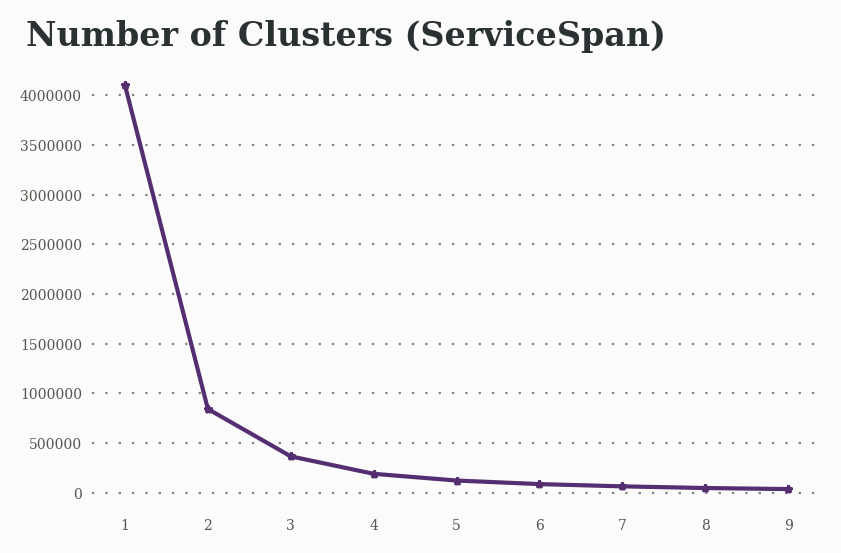

In [316]:
sse = {}
df_cluster = df[['ServiceSpan']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    
# Setting up figure and axes
fig = plt.figure(figsize=(16, 10), dpi=200) # create figure
gs = fig.add_gridspec(3, 3)
# gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])

# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

ax0.plot(list(sse.keys()), list(sse.values()), marker='*', color='#542e71')
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=5) # xticklabels rotation
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5) # yticklabels rotation
ax0.set_ylabel('') # set xlabel
ax0.set_xlabel('') # set ylabel
ax0.tick_params(axis='both', which='both', length=0) # tick length
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5)) # grid lines
for loc in ['left', 'top', 'right', 'bottom']: # spines
    ax0.spines[loc].set_visible(False)

ax0.text(-0.2, 4500000, 'Number of Clusters (ServiceSpan)', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')

plt.show()

In [319]:
kmeans = KMeans(n_clusters=4)
df['ss_cluster'] = kmeans.fit_predict(df[['ServiceSpan']])

df = order_cluster('ServiceSpan', 'ss_cluster', df, True)
df = df.drop('ServiceSpan', axis=1)

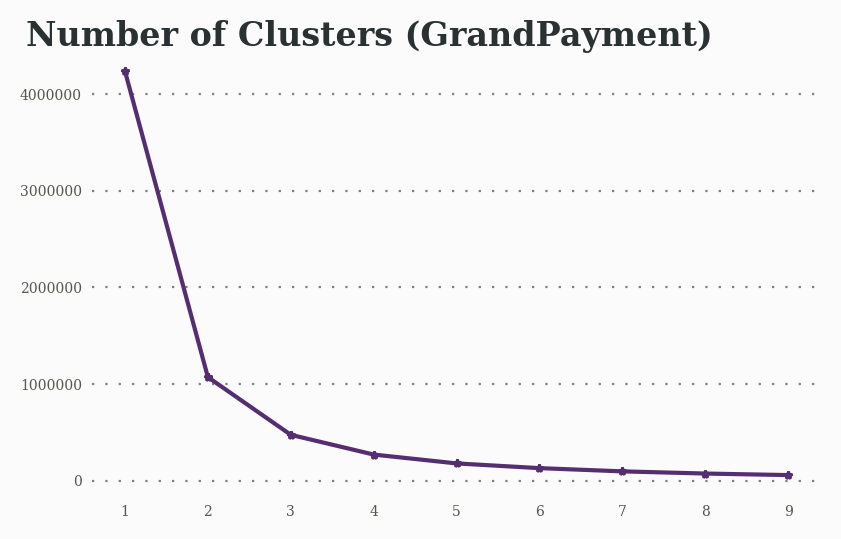

In [320]:
sse = {}
df_cluster = df[['GrandPayment']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_cluster)
    df_cluster["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
    
# Setting up figure and axes
fig = plt.figure(figsize=(16, 10), dpi=200) # create figure
gs = fig.add_gridspec(3, 3)
# gs.update(wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, 0])

# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

ax0.plot(list(sse.keys()), list(sse.values()), marker='*', color='#542e71')
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=5) # xticklabels rotation
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5) # yticklabels rotation
ax0.set_ylabel('') # set xlabel
ax0.set_xlabel('') # set ylabel
ax0.tick_params(axis='both', which='both', length=0) # tick length
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5)) # grid lines
for loc in ['left', 'top', 'right', 'bottom']: # spines
    ax0.spines[loc].set_visible(False)

ax0.text(-0.2, 4500000, 'Number of Clusters (GrandPayment)', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')

plt.show()

In [321]:
kmeans = KMeans(n_clusters=3)
df['gp_cluster'] = kmeans.fit_predict(df[['GrandPayment']])

df = order_cluster('GrandPayment', 'ss_cluster', df, True)
df = df.drop('GrandPayment', axis=1)

In [322]:
df.skew()

Aged                    1.833633
CyberProtection         0.943722
TechnicalAssistance     0.924630
SettlementProcess      -0.217557
QuarterlyPayment       -0.221862
CustomerAttrition       1.064812
GP / QP                 0.260851
GP / ServiceSpan       20.332762
QP / ServiceSpan        4.177255
aged_married            1.063135
aged_dependents         0.929901
married_dependents      0.214408
cyber_tech              0.888980
ss_cluster              0.045031
gp_cluster             -0.031674
dtype: float64

In [323]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Aged                 7043 non-null   int64  
 1   CyberProtection      7043 non-null   int64  
 2   TechnicalAssistance  7043 non-null   int64  
 3   SettlementProcess    7043 non-null   int64  
 4   QuarterlyPayment     7043 non-null   float64
 5   CustomerAttrition    6338 non-null   float64
 6   GP / QP              7043 non-null   float64
 7   GP / ServiceSpan     7043 non-null   float64
 8   QP / ServiceSpan     7043 non-null   float64
 9   aged_married         7043 non-null   int64  
 10  aged_dependents      7043 non-null   int64  
 11  married_dependents   7043 non-null   int64  
 12  cyber_tech           7043 non-null   int64  
 13  ss_cluster           7043 non-null   int32  
 14  gp_cluster           7043 non-null   int32  
dtypes: float64(5), int32(2), int64(8)
memo

,Aged,CyberProtection,TechnicalAssistance,SettlementProcess,QuarterlyPayment,CustomerAttrition,GP / QP,GP / ServiceSpan,QP / ServiceSpan,aged_married,aged_dependents,married_dependents,cyber_tech,ss_cluster,gp_cluster
0,0,0,1,2,96.259802,1.0,48.079562,94.451615,1.964486,0,1,1,1,0,1
1,0,0,0,0,18.876470,0.0,48.848434,20.045348,0.410358,1,0,2,0,0,0
2,1,1,1,1,106.016057,1.0,58.537275,103.431519,1.766934,3,2,2,3,2,1
3,0,0,0,2,80.108839,0.0,15.586987,83.243693,5.340589,0,0,0,0,1,0
4,0,0,0,2,51.529773,0.0,24.943274,49.435434,1.981914,1,1,3,0,3,0


In [324]:
target_col = 'CustomerAttrition'
mask = df[target_col].isna() == True

tr = df.loc[~mask]
tr[target_col] = tr[target_col]

te = df.loc[mask].drop(target_col, axis=1)

In [325]:
X = tr.drop('CustomerAttrition', axis=1)
y = tr['CustomerAttrition']

In [326]:
# X['rand_cat1'] = np.random.randint(low=0, high=4, size=(X.shape[0], ))

# X['rand_num1'] = np.random.rand(X.shape[0])

In [333]:
rfc = RandomForestClassifier(n_estimators=215, max_depth=7, random_state=1234, class_weight={1: 2, 0: 1})

scores = cross_val_score(rfc, X, y, cv=10)
print(scores)
print(scores.mean())

rfc.fit(X, y)

[0.77287066 0.75867508 0.77760252 0.78706625 0.76498423 0.79652997
 0.75709779 0.74605678 0.80884676 0.76461295]
0.7734342996396908


RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=7, n_estimators=215,
                       random_state=1234)

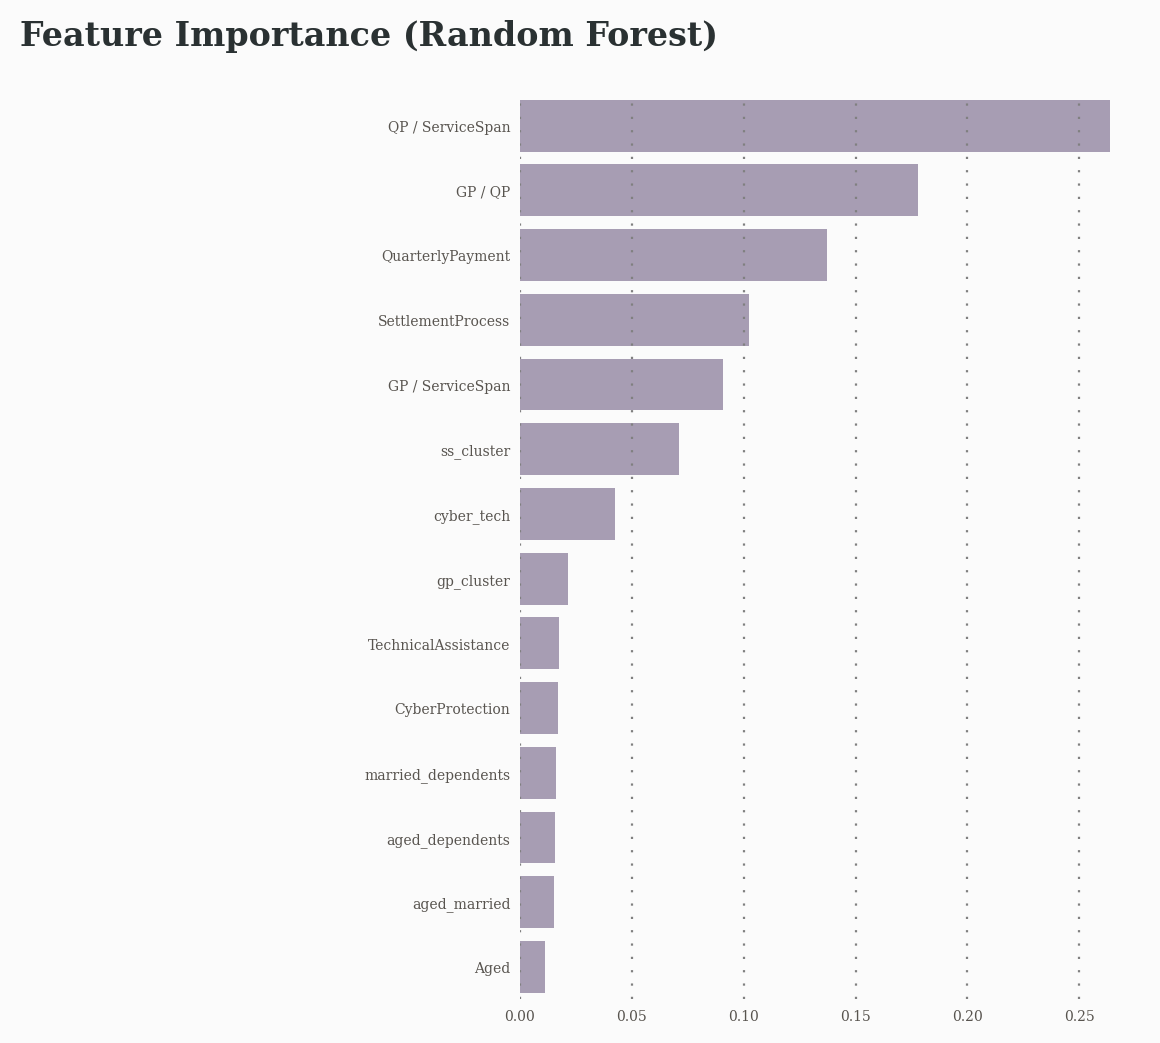

In [275]:
feat_imp = pd.DataFrame({
    'feats': X.columns.tolist(),
    'imp': rfc.feature_importances_,
}).sort_values(by='imp', ascending=False)


# Setting up figure and axes
fig = plt.figure(figsize=(4, 6), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=1)
ax0 = fig.add_subplot(gs[0, 0])


# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

c = ['#a799b7'] * 24
# idx = feat_imp['feats'].values.tolist().index('rand_cat1')
# idx2 = feat_imp['feats'].values.tolist().index('rand_num1')
# c[idx] = '#542e71'
# c[idx2] = '#542e71'


sns.barplot(data=feat_imp, x='imp', y='feats', palette=c, ax=ax0)
# ax0.axhline(y=idx, linestyle='dotted', c='#fdca40')
# ax0.axhline(y=idx2, linestyle='dotted', c='#fdca40')

plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5)
ax0.set_ylabel('')
ax0.set_xlabel('')
ax0.tick_params(axis='both', which='both', length=0)
ax0.grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
for loc in ['left', 'top', 'right', 'bottom']:
    ax0.spines[loc].set_visible(False)

fig.text(-0.5, 0.92, 'Feature Importance (Random Forest)', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')
# fig.text(-0.52, 0.88, 
#          '''
#          All the features have positive skewness except 
#          damage ratio, and we see that err_malign shows 
#          very high skewness.
#          ''',
#          fontsize=5,
#          fontfamily='serif',
#          color='#2a3132',
# )

plt.tight_layout()
plt.show()

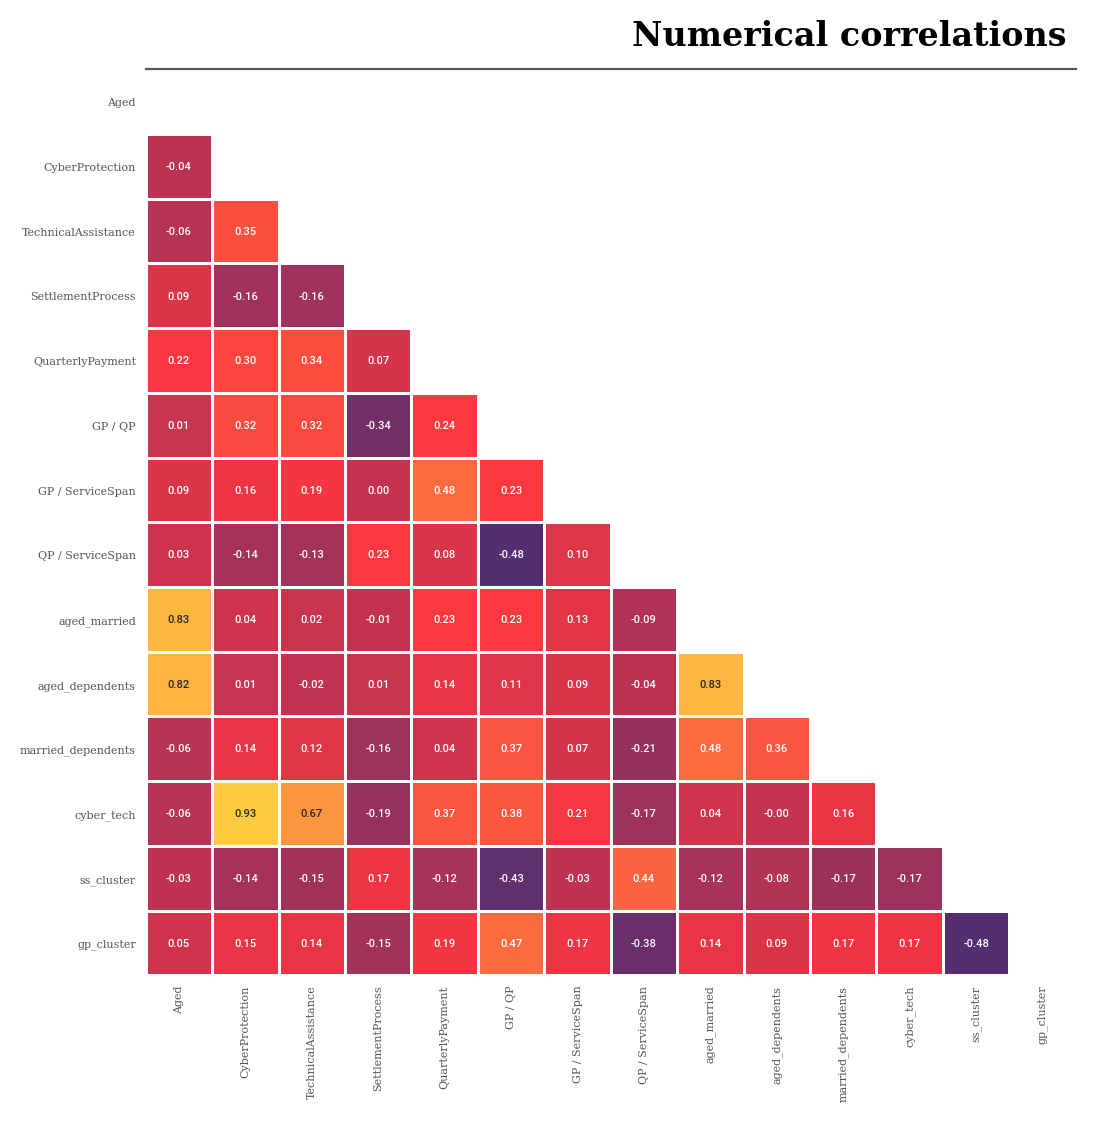

In [276]:
corr = X.corr()

# Setting up figure and axes
fig = plt.figure(figsize=(6, 6), dpi=200) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0, hspace=0.8)
ax0 = fig.add_subplot(gs[0, 0]) # create axis

mask = np.triu(corr)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#542e71', '#fb3640', '#fdca40'])

sns.heatmap(corr, mask=mask, annot=True, cbar=False, fmt='.2f',
            linewidths=0.5, cmap=cmap, ax=ax0, annot_kws={'fontweight': 'bold', 'fontsize': 4})

ax0.set_yticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation = 0, fontsize=4)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=4)

ax0.spines['top'].set_visible(True)
ax0.tick_params(axis='both', which='both', length=0)

fig.text(0.53, 0.90, 'Numerical correlations', fontweight='bold', 
         fontfamily='serif', fontsize=12, ha='left')
# fig.text(0.91, 0.88, '''
# We observe here that performance 
# in one area is strongly correlated 
# to peformance in other areas.
# It is also interesting how
# negatively correlated free lunches 
# are with performance, 
# speaking to parental 
# socio-economic status.''', 
#          fontweight='light', fontfamily='serif', fontsize=6, va='top', ha='right')

plt.tight_layout()
plt.show()

In [141]:
feat_imp.iloc[idx + 1:]['feats'].values.tolist()

['sex_dependent',
 'TotalDependents',
 'sex_age',
 'film_hardware',
 '4g_mobile',
 'mobile_hardware',
 'sex_married',
 'HardwareSupport',
 'Married',
 '4GService',
 'FilmSubscription',
 'sex',
 'MobileService']

In [ ]:
'''
All important matplotlib functions

# Setting up figure and axes
fig = plt.figure(figsize=(24, 24), dpi=200) # create figure
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0, hspace=0.5)
ax0 = fig.add_subplot(gs[0, 0])

# # Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)


# colormap for heatmap
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# set ylabels to the right
axx[2].yaxis.tick_right()

# draw the plot before getting labels
plt.draw()

ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=60, fontsize=5) # xticklabels rotation
ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=5) # yticklabels rotation
ax0.set_ylabel('') # set xlabel
ax0.set_xlabel('') # set ylabel
ax0.tick_params(axis='both', which='both', length=0) # tick length
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5)) # grid lines
for loc in ['left', 'top', 'right', 'bottom']: # spines
    ax0.spines[loc].set_visible(False)


fig.text(0.05, 1, 'Random text', fontsize=12, fontfamily='serif', 
         fontweight='bold', color='#2a3132')


plt.tight_layout()
plt.show()
'''

In [328]:
tr.to_csv('../data/fe_train2.csv', index=False)
te.to_csv('../data/fe_test2.csv', index=False)